In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# Set the folder containing CSV files
csv_folder = './scoring_outputs'

# Define model groups
groups = {
    'Masked LM': ['ESM2', 'AntiBERTy', 'CurrAb', 'SaProt', 'ProSST', 'ESM3-Open-structure'],
    "Autoregressive LM": ['HLA_progen2-large', 'HLA_ProtGPT2'],
    'Inverse Folding': ['ProteinMPNN', 'ESMIF1', "Antifold"],
    'Diffusion': ['diffab', 'diffab_fixbb'],
    'Graph Model': ['MEAN', 'MEAN_fixbb', 'dyMEAN', 'dyMEAN_fixbb'],
    'Biophysics': ['epitopeSA', 'FoldX']
}

# Define desired dataset order
dataset_order = [
    '1mhp', '1mlc', '1n8z', '2fjg',
    '3gbn_h1', '3gbn_h9',
    '4fqi_h1', '4fqi_h3',
    'aayl49', 'aayl49_ML', 'aayl51'
]

# Models to plot
models_to_plot = []
for group_cols in groups.values():
    models_to_plot.extend(group_cols)

# Prepare lists for group names, sizes, and ordered columns
group_names = []
group_sizes = []
ordered_columns = []
for group, cols in groups.items():
    group_names.append(group)
    group_sizes.append(len(cols))
    ordered_columns.extend(cols)

# Collect results
data = {}

# Define special columns for specific models
special_columns = {
    'FoldX': 'dg',
    'epitopeSA': 'EpitopeSASA (mut)'
}

# Define fixbb models and their source base models
fixbb_sources = {
    'MEAN_fixbb': ('MEAN', 'log-likelihood (fixed backbone)'),
    'dyMEAN_fixbb': ('dyMEAN', 'log-likelihood (fixed backbone)'),
    'diffab_fixbb': ('diffab', 'log-likelihood (fixed backbone)')
}

# Models that need to negate target values before correlation
negate_models = ['epitopeSA', 'FoldX']

# Cache for loaded CSV files
csv_cache = {}

# Iterate over CSV files
for filename in os.listdir(csv_folder):
    if filename.endswith('.csv'):
        filepath = os.path.join(csv_folder, filename)

        # Extract dataset and model names correctly
        dataset_part, model_part = filename.split('_benchmarking_data_')
        model_part = model_part.replace('-scores.csv', '').replace('_scores.csv', '')

        dataset_name = dataset_part

        df = pd.read_csv(filepath)
        csv_cache[(dataset_name, model_part)] = df

# Compute correlation
for (dataset_name, model_part) in csv_cache.keys():
    df = csv_cache[(dataset_name, model_part)]

    if dataset_name not in data:
        data[dataset_name] = {}

    # Determine target column
    target_column = 'log-likelihood'
    for key in special_columns:
        if model_part.startswith(key):
            target_column = special_columns[key]
            break

    if model_part not in fixbb_sources:
        if 'binding_score' in df.columns and target_column in df.columns:
            binding_score = df['binding_score']
            target_values = df[target_column]

            # If model requires negation, apply it
            if model_part in negate_models:
                target_values = -target_values

            corr = pd.concat([binding_score, target_values], axis=1).corr(method='spearman').iloc[0, 1]
            data[dataset_name][model_part] = corr
        else:
            print(f"Warning: Missing columns for {model_part} in {dataset_name}")

# Handle fixbb models separately
for fixbb_model, (base_model, ll_col) in fixbb_sources.items():
    for (dataset_name, model_part) in csv_cache.keys():
        if model_part.startswith(base_model):
            df = csv_cache[(dataset_name, model_part)]
            if 'binding_score' in df.columns and ll_col in df.columns:
                binding_score = df['binding_score']
                target_values = df[ll_col]

                corr = pd.concat([binding_score, target_values], axis=1).corr(method='spearman').iloc[0, 1]
                if dataset_name not in data:
                    data[dataset_name] = {}
                data[dataset_name][fixbb_model] = corr
            else:
                print(f"Warning: Missing columns for {fixbb_model} in {dataset_name}")

# Convert to DataFrame
result_df = pd.DataFrame.from_dict(data, orient='index')

# Fill missing columns and reorder
for col in ordered_columns:
    if col not in result_df.columns:
        result_df[col] = np.nan

# Reorder columns according to ordered_columns
result_df = result_df[ordered_columns]

# (Optional) Sort datasets if needed
result_df = result_df.reindex(dataset_order)

result_df


,ESM2,AntiBERTy,CurrAb,SaProt,ProSST,ESM3-Open-structure,HLA_progen2-large,HLA_ProtGPT2,ProteinMPNN,ESMIF1,Antifold,diffab,diffab_fixbb,MEAN,MEAN_fixbb,dyMEAN,dyMEAN_fixbb,epitopeSA,FoldX
1mhp,0.127463,-0.182426,0.284192,-0.232085,-0.208734,-0.255640,-0.377699,-0.096158,-0.283376,-0.357779,-0.267340,-0.159976,-0.144784,-0.212485,-0.206776,-0.074329,0.280697,-0.166704,0.240549
1mlc,0.020519,-0.242444,0.156126,0.232781,0.008814,-0.300949,-0.286924,-0.211959,-0.326904,-0.357426,-0.443290,0.034429,0.012676,0.024769,0.023970,0.018137,0.026205,0.101965,-0.052793
1n8z,-0.130877,-0.240285,-0.386578,0.114978,-0.258609,-0.116618,-0.208602,0.146341,-0.172436,-0.108296,0.161224,-0.023196,0.042532,0.154996,0.155509,-0.002824,-0.000892,0.174671,-0.283874
2fjg,0.078131,0.109430,0.165483,-0.160485,0.086115,0.128046,0.270414,0.037205,0.493172,0.550348,0.440915,-0.012553,-0.050288,-0.176849,-0.176838,0.025021,-0.022444,-0.020099,-0.008911
3gbn_h1,0.232052,-0.722523,0.160601,0.534774,-0.296582,-0.236129,-0.755526,-0.391265,0.586754,0.594892,0.124031,0.673590,0.538020,-0.241485,-0.202963,-0.020733,-0.021577,-0.256544,0.594688
3gbn_h9,0.380222,-0.747587,0.227788,0.600812,-0.072734,-0.220248,-0.624503,-0.176341,0.639572,0.539698,0.272006,0.613932,0.759517,-0.000117,-0.044552,-0.023759,0.003642,-0.197197,0.322525
4fqi_h1,-0.022822,-0.377658,0.186690,0.477456,-0.072022,-0.196771,-0.447780,-0.201738,0.607048,0.645777,0.419148,0.000340,-0.002155,-0.598226,-0.357335,0.034452,0.042946,-0.142421,0.637180
4fqi_h3,-0.016996,-0.195018,0.133791,0.279071,0.096763,0.031437,-0.320335,-0.001388,0.415446,0.493760,0.374257,-0.007057,-0.001422,-0.281153,-0.206804,0.021026,0.021543,-0.150171,0.285696
aayl49,-0.037086,0.212488,0.028324,-0.268689,0.128110,0.386034,0.257772,0.063350,0.404992,0.387226,0.394972,0.149267,0.176968,0.065944,0.059941,-0.030499,0.017866,0.045729,-0.012972
aayl49_ML,-0.135925,-0.136959,0.197459,0.106700,-0.012907,0.121700,-0.112436,0.045816,0.339398,0.266201,0.135659,0.002256,-0.006325,0.016691,0.019167,-0.009604,0.022862,-0.182921,0.243168


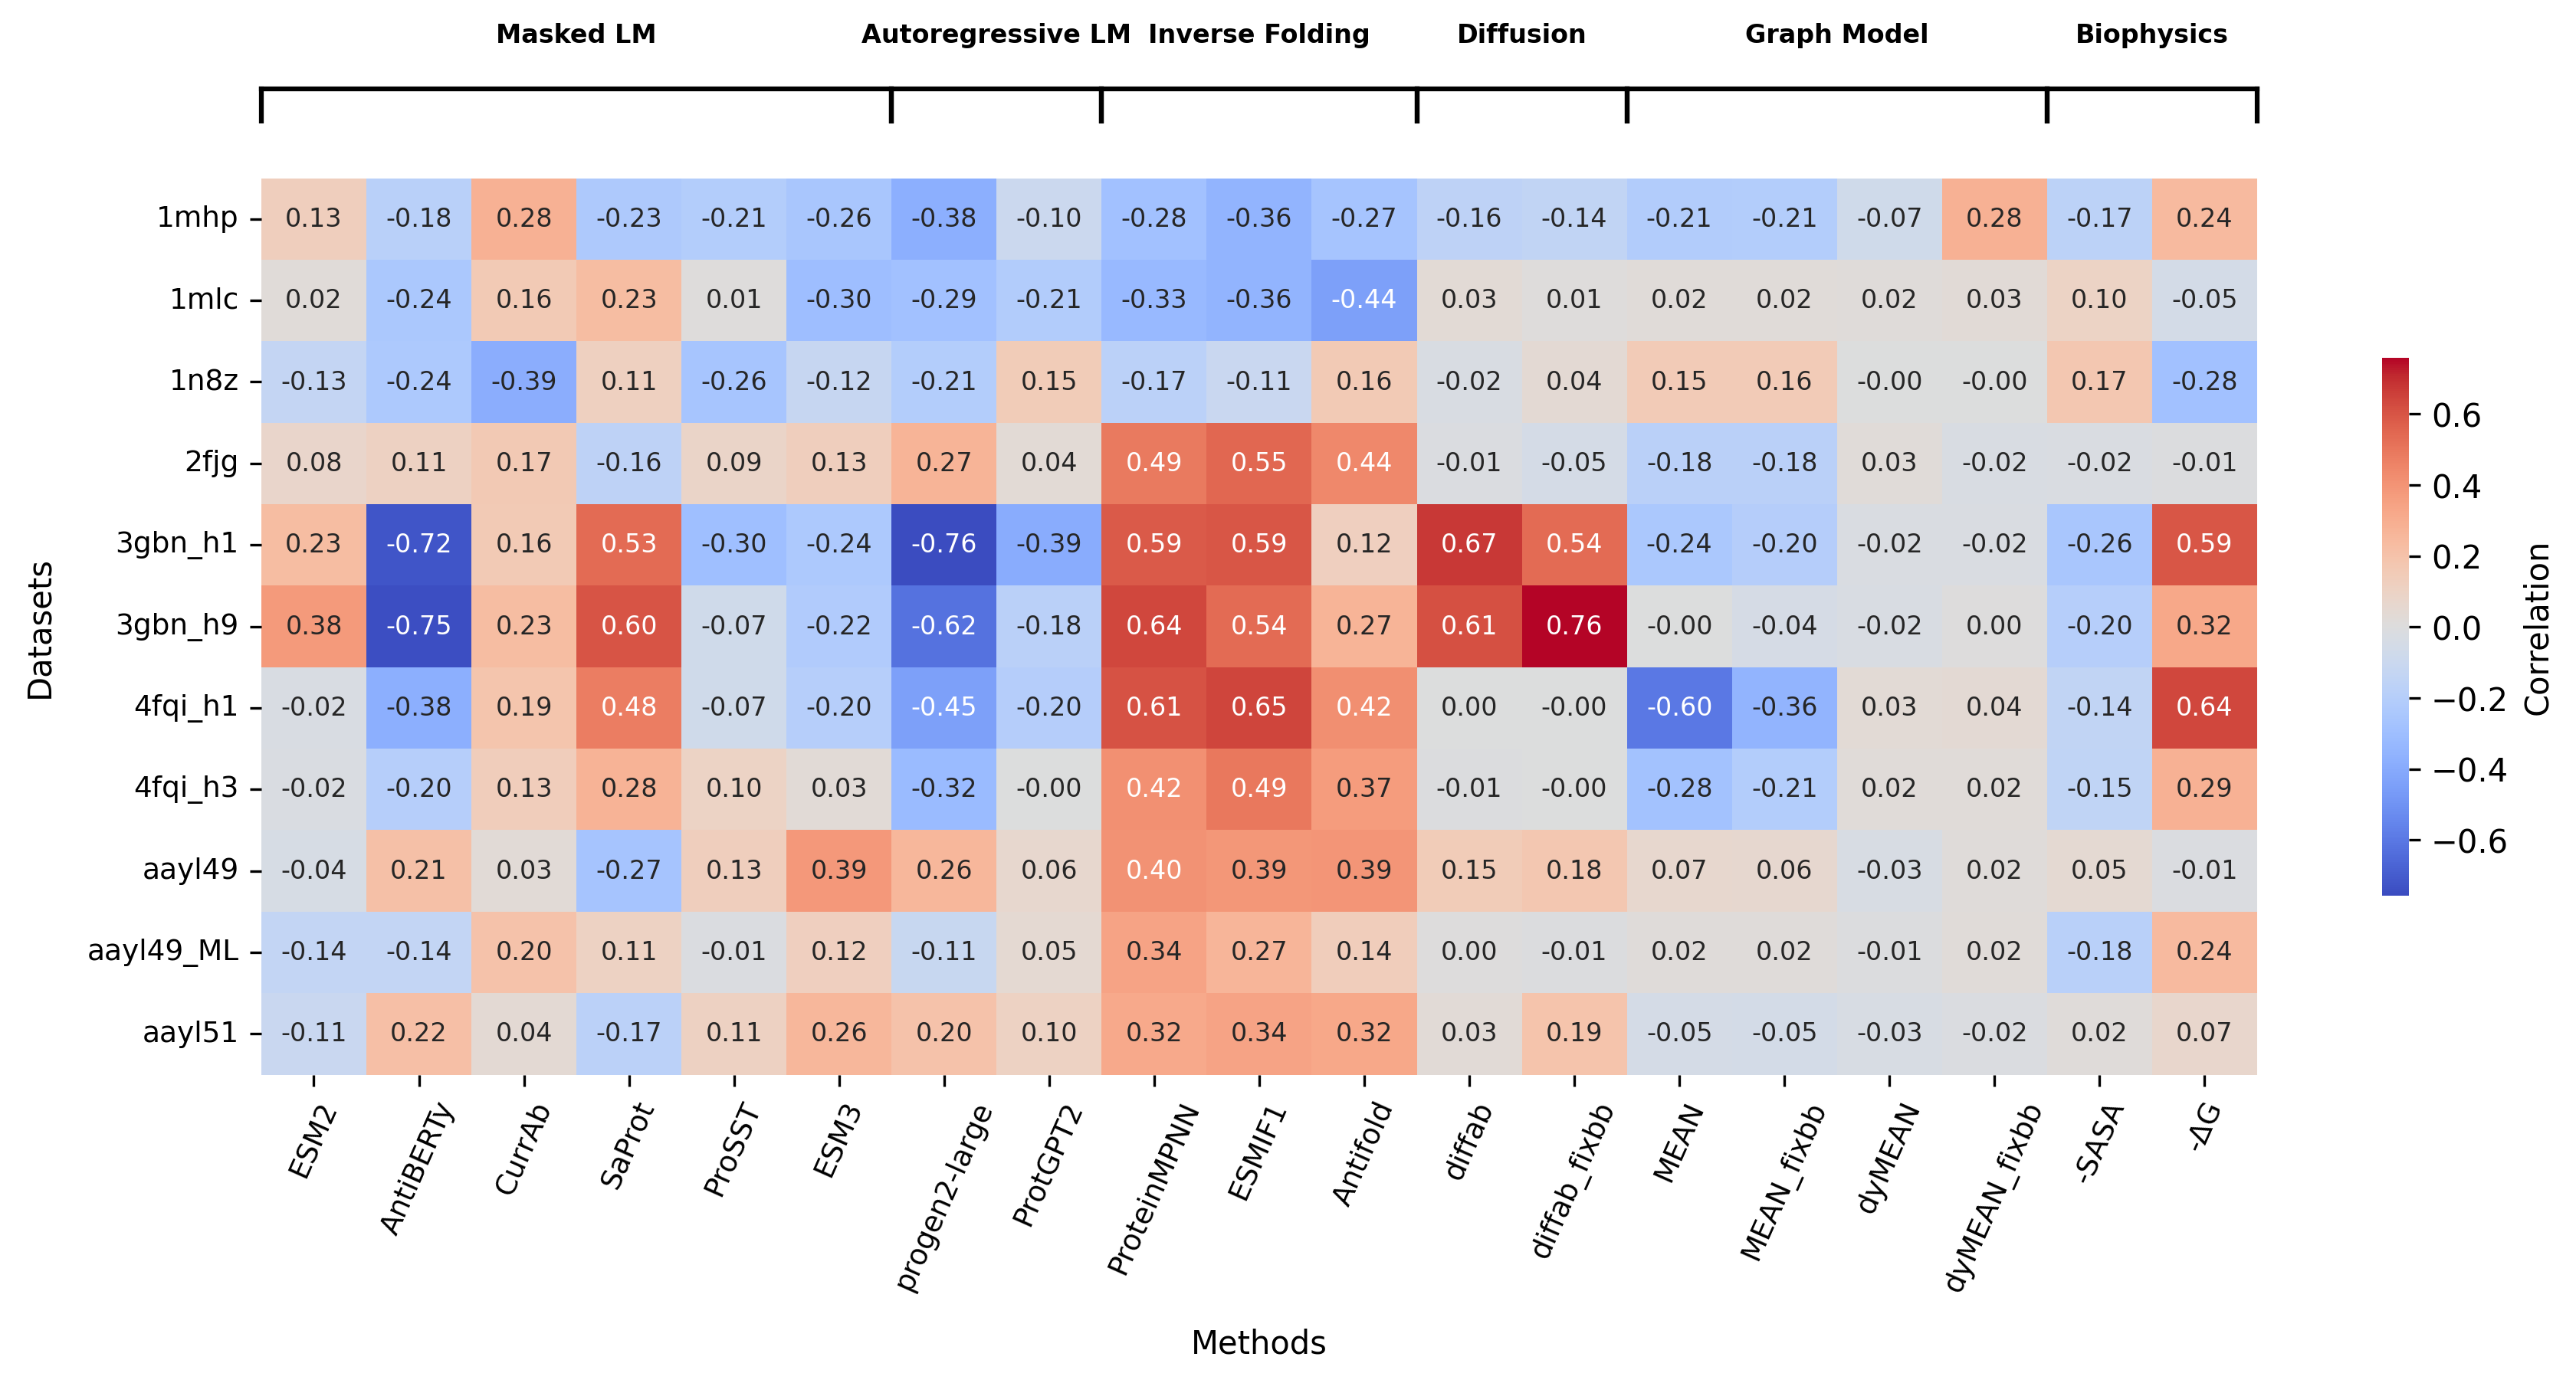

In [3]:
result_df = result_df[ordered_columns]
result_df = result_df.reindex(dataset_order)

rename_dict = {
    # 'HLA_progen2-small':'progen2-small', 
    # 'HLA_progen2-medium':'progen2-medium', 
    'HLA_progen2-large':'progen2-large',
    # 'AHL_progen2-small': 'progen2-small_AHL', 
    # 'AHL_progen2-medium': 'progen2-medium_AHL', 
    # 'AHL_progen2-large': 'progen2-large_AHL', 
    'HLA_ProtGPT2': 'ProtGPT2', 
    # 'AHL_ProtGPT2': 'ProtGPT2_AHL'   
    # 'ESM3-Open': 'ESM3 w/o structure', 
    'ESM3-Open-structure': 'ESM3',
    'FoldX': '-ΔG',
    'epitopeSA': '-SASA'
}
result_df = result_df.rename(columns=rename_dict)

# # Select columns for plotting
plot_df = result_df

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
sns.heatmap(plot_df, cmap="coolwarm", center=0,
            xticklabels=True, yticklabels=True,
            annot=True, fmt=".2f", annot_kws={"size": 8},
            cbar_kws={"label": "Correlation", "shrink": 0.6},
            ax=ax)

# Annotate groups
group_starts = np.cumsum([0] + group_sizes[:-1])
group_ends = np.cumsum(group_sizes)

for i, (start, end) in enumerate(zip(group_starts, group_ends)):
    mid = (start + end - 1) / 2
    ax.text(mid + 0.5, -1.6, group_names[i], ha='center', va='bottom',
            fontsize=8, fontweight='bold')
    ax.plot([start, end], [-1.1, -1.1], color='black', lw=1.5, clip_on=False)
    ax.plot([start, start], [-1.1, -0.7], color='black', lw=1.5, clip_on=False)
    ax.plot([end, end], [-1.1, -0.7], color='black', lw=1.5, clip_on=False)

ax.set_xlabel("Methods", fontsize=10, labelpad=10)
ax.set_ylabel("Datasets", fontsize=10, labelpad=10)
ax.set_xticklabels(result_df.columns, fontsize=9, rotation=66)
ax.set_yticklabels(result_df.index, fontsize=9, rotation=0)
plt.subplots_adjust(bottom=0.3, top=0.95)
# plt.title("Correlation Heatmap: Structures × Models", fontsize=14)
plt.show()

fig.savefig("Figure_correlation_heatmap.pdf", bbox_inches="tight")


In [4]:
# Set the folder containing CSV files
csv_folder = './scoring_outputs'

# Define model groups
groups = {
    'Masked LM': ['ESM2', 'AntiBERTy', 'CurrAb', 'SaProt', 'ProSST', 'ESM3-Open-structure'],
    "Autoregressive LM": ['HLA_progen2-large', 'HLA_ProtGPT2'],
    'Inverse Folding': ['ProteinMPNN', 'ESMIF1', "Antifold"],
    'Diffusion': ['diffab', 'diffab_fixbb'],
    'Graph Model': ['MEAN', 'MEAN_fixbb', 'dyMEAN', 'dyMEAN_fixbb'],
    'Biophysics': ['epitopeSA', 'FoldX']
}

# Define desired dataset order
dataset_order = [
    '1mhp', '1n8z',
    '3gbn_h1', '3gbn_h9',
    '4fqi_h1', '4fqi_h3',
    'aayl49', 'aayl49_ML', 'aayl51'
]

# Define special columns for specific models
special_columns = {
    'FoldX': 'dg',
    'epitopeSA': 'EpitopeSASA (mut)'
}

# Define fixbb models and their source base models
fixbb_sources = {
    'MEAN_fixbb': ('MEAN', 'log-likelihood (fixed backbone)'),
    'dyMEAN_fixbb': ('dyMEAN', 'log-likelihood (fixed backbone)'),
    'diffab_fixbb': ('diffab', 'log-likelihood (fixed backbone)')
}

# Models that need to negate target values before sorting
negate_models = ['epitopeSA', 'FoldX']

# Define wildtype binding scores (pKd) for each dataset
wildtype_binding_scores = {
    '1mhp': 8.155, '1n8z': 8.712198270069774,
    '3gbn_h1': 7, '3gbn_h9': 7,
    '4fqi_h1': 8.424622015254007, '4fqi_h3': 6,
    'aayl49': 8.848776, 'aayl49_ML': 8.848776, 'aayl51': 8.879555
}

# Set n-fold cutoff
n_fold_cutoff = 5  # means at least n_fold_cutoff x improvement

# Prepare group names and ordered columns
group_names = []
group_sizes = []
ordered_columns = []
for group, cols in groups.items():
    group_names.append(group)
    group_sizes.append(len(cols))
    ordered_columns.extend(cols)

# Collect results
data = {}

# Cache loaded CSVs
csv_cache = {}

# Iterate over CSV files
for filename in os.listdir(csv_folder):
    if filename.endswith('.csv'):
        filepath = os.path.join(csv_folder, filename)
        dataset_part, model_part = filename.split('_benchmarking_data_')
        model_part = model_part.replace('-scores.csv', '').replace('_scores.csv', '')

        dataset_name = dataset_part
        df = pd.read_csv(filepath)
        csv_cache[(dataset_name, model_part)] = df

# Compute n-fold improvement ratios
for dataset_name in dataset_order:
    for model_part in ordered_columns:
        if dataset_name not in data:
            data[dataset_name] = {}

        if model_part in fixbb_sources:
            base_model, target_column = fixbb_sources[model_part]
            df = csv_cache.get((dataset_name, base_model))
        else:
            df = csv_cache.get((dataset_name, model_part))
            target_column = 'log-likelihood'
            for key in special_columns:
                if model_part.startswith(key):
                    target_column = special_columns[key]
                    break

        if df is not None and 'binding_score' in df.columns and target_column in df.columns:
            target_values = df[target_column]

            # If model requires negation, apply it
            if model_part in negate_models:
                target_values = -target_values

            df_sorted = df.assign(target_for_sort=target_values).sort_values(by='target_for_sort', ascending=False)
            top10 = df_sorted.head(10)
            if len(top10) > 0:
                wt_pkd = wildtype_binding_scores.get(dataset_name, np.nan)
                if not np.isnan(wt_pkd):
                    delta_pkd = top10['binding_score'] - wt_pkd
                    fold_improvement = 10 ** delta_pkd
                    n_fold_count = (fold_improvement >= n_fold_cutoff).sum()
                    proportion = n_fold_count / len(top10)
                    data[dataset_name][model_part] = proportion
                else:
                    print(f"Warning: No wildtype score for {dataset_name}")
            else:
                print(f"Warning: No valid top10 for {dataset_name} - {model_part}")
        else:
            print(f"Warning: Missing required columns for {dataset_name} - {model_part}")

# Convert to DataFrame
result_df = pd.DataFrame.from_dict(data, orient='index')

# Fill missing columns and reorder
for col in ordered_columns:
    if col not in result_df.columns:
        result_df[col] = np.nan

# Reorder columns according to ordered_columns
result_df = result_df[ordered_columns]

# (Optional) Sort datasets if needed
result_df = result_df.reindex(dataset_order)

result_df


,ESM2,AntiBERTy,CurrAb,SaProt,ProSST,ESM3-Open-structure,HLA_progen2-large,HLA_ProtGPT2,ProteinMPNN,ESMIF1,Antifold,diffab,diffab_fixbb,MEAN,MEAN_fixbb,dyMEAN,dyMEAN_fixbb,epitopeSA,FoldX
1mhp,0.5,0.3,0.7,0.4,0.4,0.4,0.2,0.4,0.3,0.2,0.2,0.4,0.5,0.4,0.3,0.5,0.6,0.5,0.5
1n8z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3gbn_h1,1.0,0.0,1.0,1.0,0.9,0.7,0.0,0.2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.9,0.9,0.8
3gbn_h9,1.0,0.0,0.9,1.0,0.9,0.3,0.2,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,0.8,0.3,0.3
4fqi_h1,0.8,0.0,1.0,1.0,1.0,0.7,0.1,0.8,1.0,1.0,1.0,0.7,0.4,0.1,0.2,0.7,0.6,0.4,1.0
4fqi_h3,0.0,0.0,0.2,0.6,0.0,0.0,0.0,0.0,0.9,1.0,0.2,0.1,0.0,0.0,0.0,0.1,0.3,0.0,0.0
aayl49,0.0,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.4,0.2,0.2,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0
aayl49_ML,0.2,0.2,0.2,0.1,0.2,0.5,0.2,0.2,0.6,0.6,0.7,0.2,0.2,0.0,0.0,0.2,0.5,0.2,0.2
aayl51,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


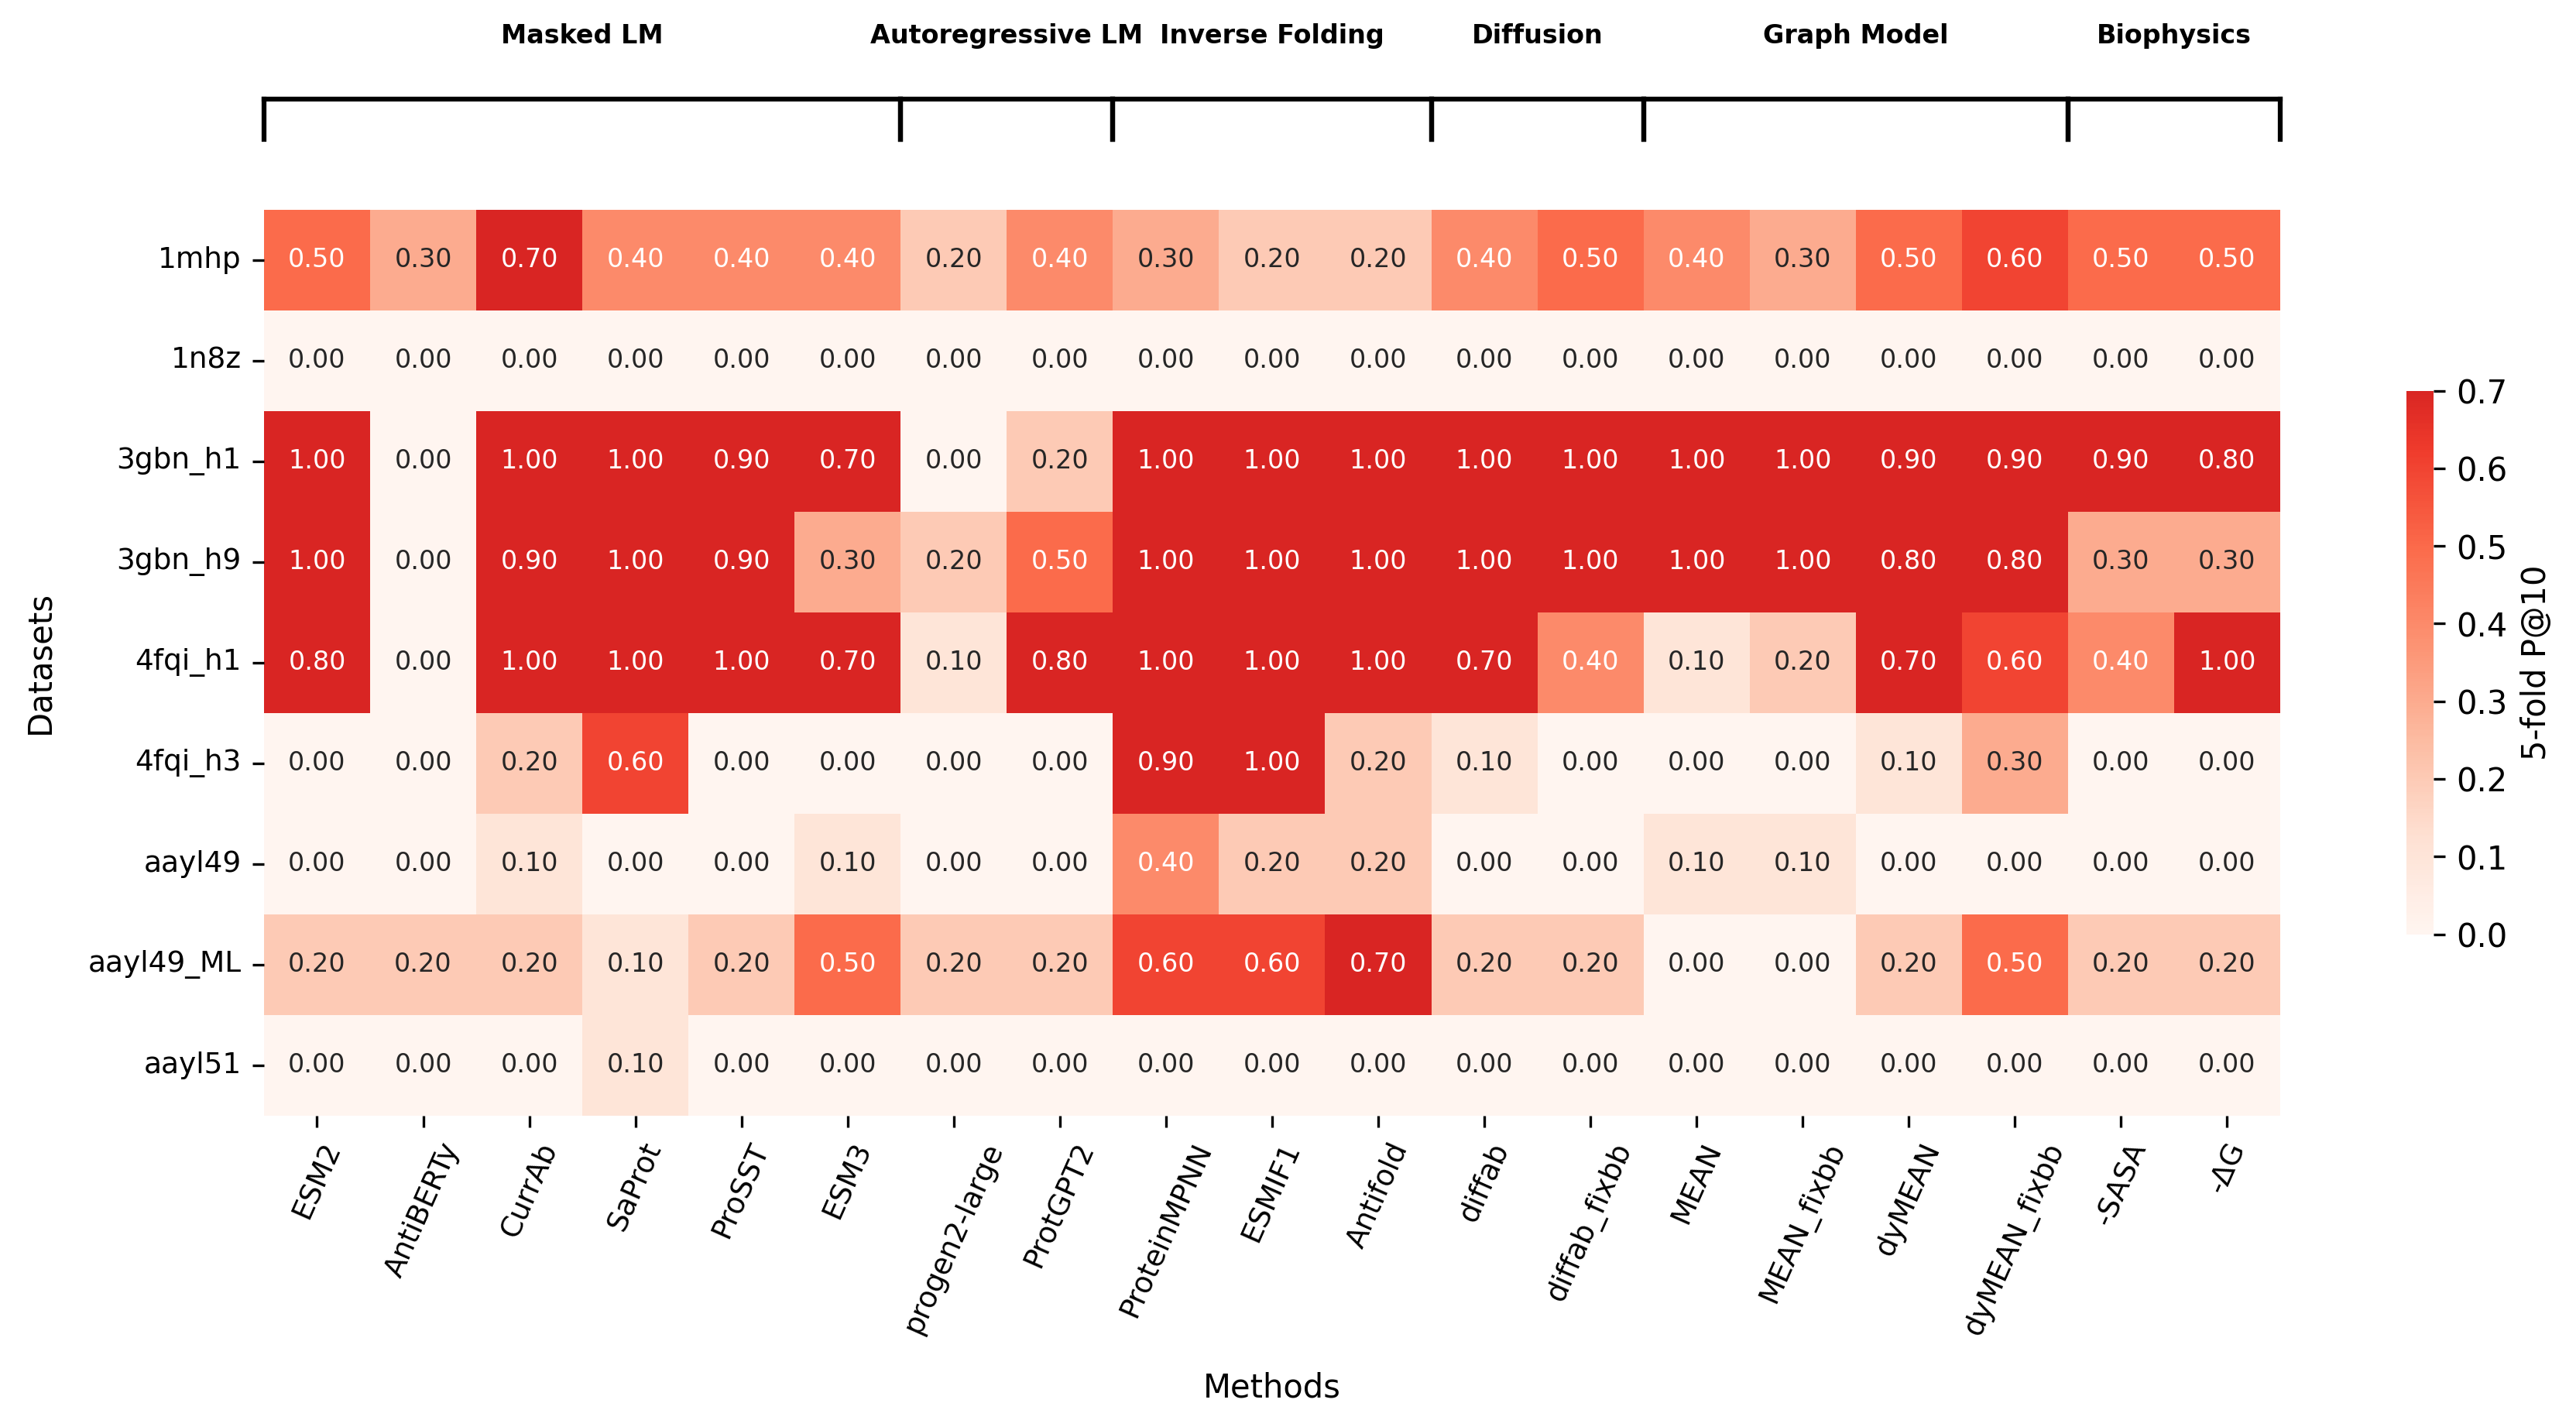

In [5]:
result_df = result_df[ordered_columns]
result_df = result_df.reindex(dataset_order)

rename_dict = {
    # 'HLA_progen2-small':'progen2-small', 
    # 'HLA_progen2-medium':'progen2-medium', 
    'HLA_progen2-large':'progen2-large',
    # 'AHL_progen2-small': 'progen2-small_AHL', 
    # 'AHL_progen2-medium': 'progen2-medium_AHL', 
    # 'AHL_progen2-large': 'progen2-large_AHL', 
    'HLA_ProtGPT2': 'ProtGPT2', 
    # 'AHL_ProtGPT2': 'ProtGPT2_AHL' 
    # 'ESM3-Open': 'ESM3 w/o structure', 
    'ESM3-Open-structure': 'ESM3',
    'FoldX': '-ΔG',
    'epitopeSA': '-SASA'
}
result_df = result_df.rename(columns=rename_dict)

n_fold = n_fold_cutoff
# Plot heatmap
# shallow_red = LinearSegmentedColormap.from_list(
#     "shallow_red", ["#ffffff", "#fde0dd", "#fa9fb5", "#f768a1"]
# )
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
sns.heatmap(result_df, cmap="Reds", vmin=0, vmax=0.7, center=0.5,
            xticklabels=True, yticklabels=True,
            annot=True, fmt=".2f", annot_kws={"size": 8},
            cbar_kws={"label": f"{n_fold}-fold P@10", "shrink": 0.6},
            ax=ax)

# Annotate groups
group_starts = np.cumsum([0] + group_sizes[:-1])
group_ends = np.cumsum(group_sizes)

for i, (start, end) in enumerate(zip(group_starts, group_ends)):
    mid = (start + end - 1) / 2
    ax.text(mid + 0.5, -1.6, group_names[i], ha='center', va='bottom',
            fontsize=8, fontweight='bold')
    ax.plot([start, end], [-1.1, -1.1], color='black', lw=1.5, clip_on=False)
    ax.plot([start, start], [-1.1, -0.7], color='black', lw=1.5, clip_on=False)
    ax.plot([end, end], [-1.1, -0.7], color='black', lw=1.5, clip_on=False)


ax.set_xlabel("Methods", fontsize=10, labelpad=10)
ax.set_ylabel("Datasets", fontsize=10, labelpad=10)
ax.set_xticklabels(result_df, fontsize=9, rotation=66)
ax.set_yticklabels(result_df.index, fontsize=9, rotation=0)
plt.subplots_adjust(bottom=0.3, top=0.95)
plt.show()

fig.savefig("Figure_nfold_improvement_heatmap.pdf", bbox_inches="tight")
